# Doublet Detection on 8k PBMCs from 10x Genomics

In [1]:
import numpy as np
# Ignore warning for convergence plot
np.warnings.filterwarnings('ignore')
import pandas as pd
import sys
import doubletdetection
import matplotlib.pyplot as plt
import tarfile
import time
from bhtsne import tsne
from sklearn.decomposition import PCA
import phenograph
plt.style.use('seaborn-muted')
%matplotlib inline

## Download Data from 10x

In [2]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
tar = tarfile.open('pbmc8k_filtered_gene_bc_matrices.tar.gz')
tar.extractall()
tar.close()

--2018-04-08 17:05:36--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com... 2600:9000:2004:b800:1d:87c0:ff40:93a1, 2600:9000:2004:7c00:1d:87c0:ff40:93a1, 2600:9000:2004:ba00:1d:87c0:ff40:93a1, ...
Connecting to cf.10xgenomics.com|2600:9000:2004:b800:1d:87c0:ff40:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  10.2MB/s    in 5.6s    

2018-04-08 17:05:43 (6.36 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



### Make Count Matrix

This function converts a 10x count matrix into a simply numpy array

In [3]:
def read_from_mtx(folder):
    import scipy.io
    from scipy.io import mmread
    bcl = []
    with open(folder + "barcodes.tsv") as f1:
        for line in f1:
            bcl.append(line.strip())
    gl = []
    with open(folder + "genes.tsv") as f2:
        for line in f2:
            arr = line.strip().split('\t')
            gl.append(arr[1].rstrip())

    gcm = np.transpose(mmread(folder + "matrix.mtx").toarray())
    return gcm, np.array(bcl), np.array(gl)

In [4]:
root = 'filtered_gene_bc_matrices/GRCh38/'
raw_counts, barcodes, genes = read_from_mtx(root)
# Remove columns with all 0s
zero_genes = np.sum(raw_counts, axis=0) == 0
raw_counts = raw_counts[:, ~zero_genes]
genes = genes[~zero_genes]

## Run Doublet Detection

Right now, phenograph is a bit talkative, so we capture the output to avoid lots of text

In [6]:
%%capture

clf = doubletdetection.BoostClassifier(knn=30)

start = time.time()
doublets = clf.fit(raw_counts)
end = time.time()

In [7]:
print('Time elapsed: {} seconds for 25 iterations'.format(np.round(end-start, 2)))

Time elapsed: 654.97 seconds for 25 iterations


## Visualize Results

## Convergence of Doublet Calls

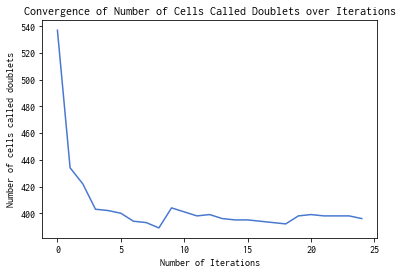

In [9]:
doubs_per_run = []
for i in range(clf.n_iters):
    cum_p_values = clf._all_p_values[:i+1]
    cum_vote_average = np.mean(np.ma.masked_invalid(cum_p_values) > 0.99, axis=0)
    cum_doublets = np.ma.filled(cum_vote_average >= 0.9, np.nan)
    doubs_per_run.append(np.sum(cum_doublets))

plt.plot(np.arange(len(doubs_per_run)), doubs_per_run)
plt.xlabel("Number of Iterations")
plt.ylabel("Number of cells called doublets")
plt.title('Convergence of Number of Cells Called Doublets over Iterations')

## Doublets on TSNE map

In [11]:
norm_counts = doubletdetection.normalize_counts(raw_counts)
reduced_counts = PCA(n_components=30, svd_solver='randomized').fit_transform(norm_counts)
communities, _, _ = phenograph.cluster(reduced_counts)
tsne_counts = tsne(reduced_counts, rand_seed=1)
tsne_counts = pd.DataFrame(tsne_counts, columns=["x", "y"], index=barcodes)

Text(0.5,0,'396 out of 8381 cells called doublets.\n 4.72% across-type doublet rate.')

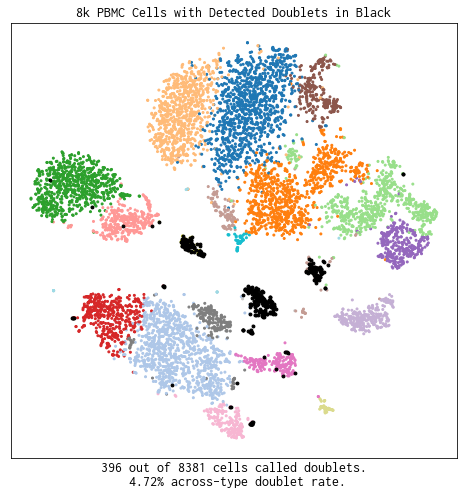

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.scatter(tsne_counts['x'], tsne_counts['y'], c=communities, cmap=plt.cm.tab20, s=4)
axes.scatter(tsne_counts[doublets]['x'], tsne_counts[doublets]['y'], s=8, edgecolor='k', facecolor='k')
axes.set_title('8k PBMC Cells with Detected Doublets in Black', fontsize=14)
plt.xticks([])
plt.yticks([])
axes.set_xlabel('{} out of 8381 cells called doublets.\n {}% across-type doublet rate.'
                .format(np.sum(doublets), 
                np.round(100*np.sum(doublets)/raw_counts.shape[0], 2)), fontsize=14)